In [2]:
# === A. 기본 임포트 & 공통 설정 ===
import os, re, random
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

# ML
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, confusion_matrix, roc_curve, auc
)

SEED = 42
random.seed(SEED); np.random.seed(SEED)
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 160)
print("Ready.")


Ready.


In [3]:
# === B. 경로/환경 설정 (여기만 내 경로로 수정) ===
DATA_PATH = "/Users/Shared/최종선_교수님/Face_skin_disease/데이터 전처리/피부 질환 화장품 데이터/여드름_스킨케어/크림/Ntoken_review.csv"                 # 리뷰 CSV (review, label 또는 rating)
POS_PATH  = "./combined_pos_words.txt"           # 긍정 단어 txt
NEG_PATH  = "./combined_neg_words.txt"           # 부정 단어 txt

TEXT_COL  = "review"
LABEL_COL = "label"   # 없으면 rating으로 이진화(>=4 → 0, <=3 → 1)
MAX_N     = 3

OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)
print("Config set.")


Config set.


In [4]:
# === C. 텍스트 정규화 ===
EMOJI_PATTERN = re.compile(
    "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
URL_PATTERN = re.compile(r"(http[s]?://\S+|www\.\S+)")
MENTION_PATTERN = re.compile(r"@[A-Za-z0-9_]+")
HASHTAG_PATTERN = re.compile(r"#[^\s#]+")

def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = str(s) if s is not None else ""
    s = s.lower().strip()
    s = URL_PATTERN.sub(" ", s)
    s = MENTION_PATTERN.sub(" ", s)
    s = HASHTAG_PATTERN.sub(" ", s)
    s = EMOJI_PATTERN.sub(" ", s)
    s = re.sub(r"(.)\1{2,}", r"\1\1", s)                 # 반복문자 축약
    s = re.sub(r"[^0-9a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ\s\.\,\!\?\%]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

print(normalize_text("👍완전~~~좋아욬ㅋㅋㅋㅠㅠ www.site.com #보습"))


완전 좋아욬ㅋㅋㅠㅠ


In [5]:
# === D. 토크나이저 (Komoran 되면 사용, 실패 시 간이 토크나이저) ===
try:
    from konlpy.tag import Komoran
    _komoran = Komoran(userdic=None)
    def tokenize(sent: str) -> List[str]:
        morphs = _komoran.pos(sent, flatten=True)
        out = []
        for w, p in morphs:
            if p.startswith(("NN","VV","VA")) or p in ("MAG","MAJ"):
                out.append(w)
        return out if out else sent.split()
    print("Tokenizer: Komoran")
except Exception as e:
    print("Tokenizer: fallback(simple). Reason:", e)
    def tokenize(sent: str) -> List[str]:
        sent = re.sub(r"[^0-9a-zA-Z가-힣\s]", " ", sent)
        sent = re.sub(r"\s+", " ", sent).strip()
        return sent.split()


Tokenizer: Komoran


In [6]:
# === E. TXT 사전 로드 (긍정/부정 단어 목록 → 가중치 사전) ===
def load_txt_lexicon(pos_path: str, neg_path: str) -> Dict[Tuple[str, ...], float]:
    lex = {}
    # 긍정
    if os.path.exists(pos_path):
        with open(pos_path, encoding="utf-8") as f:
            for line in f:
                w = line.strip()
                if not w: continue
                toks = tuple(tokenize(w))
                if toks:
                    lex[toks] = 1.0
    else:
        print(f"[WARN] not found: {pos_path}")
    # 부정
    if os.path.exists(neg_path):
        with open(neg_path, encoding="utf-8") as f:
            for line in f:
                w = line.strip()
                if not w: continue
                toks = tuple(tokenize(w))
                if toks:
                    lex[toks] = -1.0
    else:
        print(f"[WARN] not found: {neg_path}")
    return lex

lexicon = load_txt_lexicon(POS_PATH, NEG_PATH)
print("Lexicon size:", len(lexicon))


Lexicon size: 9687


In [7]:
# === F. 동의어/이형태 정규화 (선택) ===
SYN_MAP = {
    "흡수해요":"흡수","스며들어":"흡수","스며듦":"흡수",
    "따갑":"자극","촉촉":"보습","건조함":"건조"
}
def apply_syn_map(tokens: List[str]) -> List[str]:
    return [SYN_MAP.get(t, t) for t in tokens]


In [8]:
# === G. n-gram 인덱스 & 최장일치 ===
def build_ngram_index(lex: Dict[Tuple[str, ...], float], max_n=3):
    idx = {n: {} for n in range(1, max_n+1)}
    for ngram, w in lex.items():
        n = min(len(ngram), max_n)
        idx[n][ngram] = w
    return idx

def greedy_longest_match(tokens: List[str], ngram_index, max_n=3):
    i, L = 0, len(tokens)
    matches = []
    while i < L:
        found = None
        for n in range(min(max_n, L - i), 0, -1):
            cand = tuple(tokens[i:i+n])
            if cand in ngram_index[n]:
                found = (i, i+n, cand, ngram_index[n][cand])
                break
        if found:
            matches.append(found)
            i = found[1]
        else:
            i += 1
    return matches

ng_idx = build_ngram_index(lexicon, MAX_N)
print("ngram index ready.")


ngram index ready.


In [9]:
# === H. 부정어/강도부사 룰(최종 점수에만 후처리) ===
NEGATIONS = {"안","못","별로","그다지","전혀","아니","않"}
INT_POS  = {"매우","진짜","정말","완전","엄청","굉장히"}
INT_NEG  = {"약간","조금","그냥"}

def adjust_by_rules(tokens: List[str], score: float) -> float:
    # 부정어가 문장에 존재하고 점수가 양수면 살짝 반전
    if any(t in NEGATIONS for t in tokens):
        score = -score if score > 0 else score
    # 강도부사 보정
    if any(t in INT_POS for t in tokens):
        score *= 1.15
    if any(t in INT_NEG for t in tokens):
        score *= 0.9
    return score


In [10]:
# === I. 규칙 기반 스코어/라벨 ===
def score_by_lexicon(tokens: List[str], ngram_index, max_n=3) -> float:
    toks = apply_syn_map(tokens)
    matches = greedy_longest_match(toks, ngram_index, max_n=max_n)
    total = 0.0
    for (s,e,ng,w) in matches:
        total += w
    total = adjust_by_rules(toks, total)   # 최소 변경: 최종 점수만 보정
    return float(total)

def predict_lexicon(df: pd.DataFrame, text_col: str, ngram_index, max_n=3):
    scores, labels = [], []
    for s in df[text_col].fillna("").astype(str).tolist():
        toks = tokenize(normalize_text(s))
        sc = score_by_lexicon(toks, ngram_index, max_n=max_n)
        scores.append(sc)
        labels.append(0 if sc > 0 else 1)
    return np.array(scores), np.array(labels)


In [11]:
# === J. 평가지표 & 임계값 튜닝 ===
def print_report(y_true, y_pred, y_prob=None, title="Report"):
    print(f"\n== {title} ==")
    print(classification_report(y_true, y_pred, digits=4, target_names=["pos","neg"]))
    if y_prob is not None:
        try:
            print("PR-AUC :", average_precision_score(y_true, y_prob))
            print("ROC-AUC:", roc_auc_score(y_true, y_prob))
        except Exception as e:
            print("AUC calc skipped:", e)

def find_best_threshold(y_true, y_prob):
    p, r, th = precision_recall_curve(y_true, y_prob)
    f1s = (2*p*r/(p+r+1e-12))[:-1]
    if len(th) == 0:
        return 0.5
    return float(th[f1s.argmax()])


In [12]:
# === K. 실행: 데이터 로드 및 전체 파이프라인 ===
assert os.path.exists(DATA_PATH), f"DATA_PATH not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

# 라벨 생성: label > rating(>=4)
if LABEL_COL in df.columns:
    y = df[LABEL_COL].astype(int).values
elif "rating" in df.columns:
    y = (df["rating"].astype(float) < 4).astype(int).values
else:
    raise ValueError("라벨 컬럼(LABEL_COL) 또는 rating 컬럼이 필요합니다.")

# 규칙 기반
lex_scores, lex_labels = predict_lexicon(df, TEXT_COL, ng_idx, max_n=MAX_N)
print_report(y, lex_labels, title="Lexicon-Rule")

# ML Baseline (TF-IDF + LogisticRegression, 불균형 보정 1줄)
X_text = df[TEXT_COL].fillna("").astype(str).map(normalize_text).tolist()
vect = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=3, max_features=100_000)
Xv = vect.fit_transform(X_text)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
ml_preds = np.zeros_like(y)
ml_probs = np.zeros(len(y), dtype=float)

for fold, (tr, va) in enumerate(skf.split(Xv, y), 1):
    clf = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")
    clf.fit(Xv[tr], y[tr])
    p = clf.predict_proba(Xv[va])[:, 1]
    ml_probs[va] = p
    ml_preds[va] = (p >= 0.5).astype(int)
    print(f"[Fold {fold}] F1:", f1_score(y[va], ml_preds[va]))

print_report(y, ml_preds, ml_probs, title="ML Baseline")



== Lexicon-Rule ==
              precision    recall  f1-score   support

         pos     0.9642    0.0587    0.1107     11017
         neg     0.0678    0.9692    0.1267       778

    accuracy                         0.1188     11795
   macro avg     0.5160    0.5139    0.1187     11795
weighted avg     0.9051    0.1188    0.1118     11795

[Fold 1] F1: 0.3687150837988827
[Fold 2] F1: 0.3516483516483517
[Fold 3] F1: 0.41304347826086957
[Fold 4] F1: 0.43360433604336046
[Fold 5] F1: 0.38605898123324395

== ML Baseline ==
              precision    recall  f1-score   support

         pos     0.9609    0.9368    0.9487     11017
         neg     0.3397    0.4602    0.3908       778

    accuracy                         0.9054     11795
   macro avg     0.6503    0.6985    0.6698     11795
weighted avg     0.9199    0.9054    0.9119     11795

PR-AUC : 0.3450888517297276
ROC-AUC: 0.8479402479878608


In [13]:
# === L. 결과 저장 (예측/리포트/에러케이스) ===
df_out = df.copy()
df_out["lex_score"] = lex_scores
df_out["lex_pred"]  = lex_labels
df_out["ml_pred"]   = ml_preds
pred_path = os.path.join(OUT_DIR, "predictions.csv")
df_out.to_csv(pred_path, index=False, encoding="utf-8-sig")
print("Saved:", pred_path)

# 에러 케이스 top-20 (규칙/ML)
wrong_lex = np.where(y != lex_labels)[0]
wrong_ml  = np.where(y != ml_preds)[0]
df.iloc[wrong_lex].head(20).to_csv(os.path.join(OUT_DIR, "errors_lexicon_top20.csv"), index=False, encoding="utf-8-sig")
df.iloc[wrong_ml ].head(20).to_csv(os.path.join(OUT_DIR, "errors_ml_top20.csv"), index=False, encoding="utf-8-sig")
print("Saved errors CSVs.")


Saved: ./outputs/predictions.csv
Saved errors CSVs.


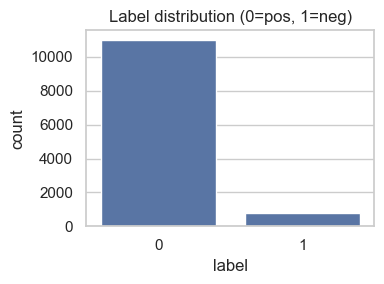

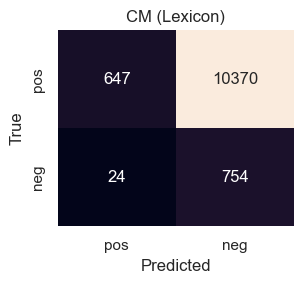

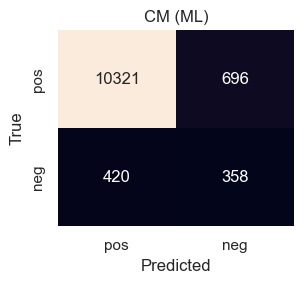

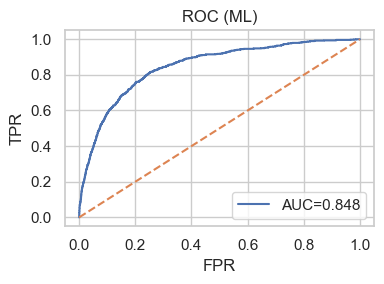

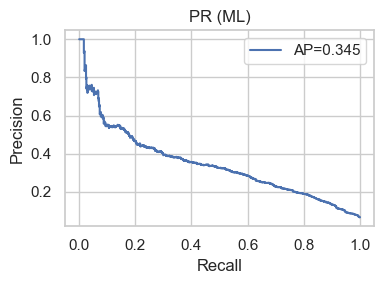

In [16]:
# === M. 시각화 (선택) ===
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    use_sns = True
except:
    use_sns = False

# 라벨 분포
plt.figure(figsize=(4,3))
vals, cnts = np.unique(y, return_counts=True)
if use_sns: sns.barplot(x=vals, y=cnts)
else: plt.bar(vals, cnts)
plt.title("Label distribution (0=pos, 1=neg)")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "viz_label_distribution.png"), dpi=180); plt.show()

# 혼동행렬
def plot_cm(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(3.2,3))
    if use_sns:
        sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["pos","neg"], yticklabels=["pos","neg"])
    else:
        plt.imshow(cm, cmap="Blues")
        for (i,j), v in np.ndenumerate(cm): plt.text(j, i, str(v), ha='center', va='center')
        plt.xticks([0,1], ["pos","neg"]); plt.yticks([0,1], ["pos","neg"])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, fname), dpi=180); plt.show()

# 아래 라인이 삭제되었습니다.
plot_cm(y, lex_labels, "CM (Lexicon)", "cm_lexicon.png")
plot_cm(y, ml_preds,  "CM (ML)",      "cm_ml.png")

# ROC/PR (ML)
fpr, tpr, _ = roc_curve(y, ml_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (ML)"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "roc_ml.png"), dpi=180); plt.show()

p, r, _ = precision_recall_curve(y, ml_probs)
pr_auc = auc(r, p)
plt.figure(figsize=(4,3))
plt.plot(r, p, label=f"AP={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (ML)"); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "pr_ml.png"), dpi=180); plt.show()

In [15]:
# === N. 요청 포맷 저장: senti_labeled_df.csv ===
from ast import literal_eval

def _to_token_list(val, fallback_text=None):
    if isinstance(val, str):
        try:
            obj = literal_eval(val)
        except Exception:
            obj = None
    else:
        obj = val
    if isinstance(obj, list):
        if len(obj) > 0 and isinstance(obj[0], tuple):  # [('형태소','품사'), ...]
            return [t[0] for t in obj]
        return list(obj)
    if fallback_text is not None:
        return tokenize(normalize_text(str(fallback_text)))
    return []

# sen (토큰 리스트)
sen_list = []
if "tokens" in df.columns:
    for i, row in df.iterrows():
        sen_list.append(_to_token_list(row["tokens"], row.get(TEXT_COL, "")))
else:
    for txt in df[TEXT_COL].fillna("").astype(str):
        sen_list.append(tokenize(normalize_text(txt)))

# pos_neg (정답: label > 기존 pos_neg > rating)
if "pos_neg" in df.columns:
    pos_neg = df["pos_neg"].astype(int).tolist()
elif "label" in df.columns:
    pos_neg = df["label"].astype(int).tolist()
elif "rating" in df.columns:
    pos_neg = (df["rating"].astype(float) >= 4).astype(int).tolist()
else:
    pos_neg = [0]*len(df)

# sen2 (동의어 정규화 후 문자열)
try:
    sen2 = [" ".join(apply_syn_map(s)) for s in sen_list]
except Exception:
    sen2 = [" ".join(s) for s in sen_list]

# senti_score / pred
senti_score = lex_scores.tolist()
# pred는 기존 df에 'pred' 있으면 그걸 우선, 없으면 규칙기반 라벨 사용
pred = df["pred"].astype(int).tolist() if "pred" in df.columns else lex_labels.astype(int).tolist()

test_sent = pd.DataFrame({
    "sen": sen_list,
    "pos_neg": pos_neg,
    "sen2": sen2,
    "senti_score": senti_score,
    "pred": pred
})
save_path = "senti_labeled_df.csv"
test_sent.to_csv(save_path, index=False, columns=["sen","pos_neg","sen2","senti_score","pred"])
print(f"✅ 결과가 {save_path}에 저장되었습니다!")


✅ 결과가 senti_labeled_df.csv에 저장되었습니다!
